In [28]:
import numpy as np 
import pandas as pd
import os
import scipy.stats as ss
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor,plot_importance
from scipy.stats import f_oneway
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import datetime
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Conv1D, Dropout, MaxPooling1D, Flatten, Embedding, Activation, LeakyReLU

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

In [15]:
# 데이터 불러오기
past_sales = pd.read_csv('C:/Users/PC/표/수요예측/rossmann-store-sales/train.csv')
store = pd.read_csv('C:/Users/PC/표/수요예측/rossmann-store-sales/store.csv')

# 데이터 제거
store = store.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1)

# 데이터 병합
data = pd.merge(left = past_sales,right = store, on = 'Store', how = 'right')

# 날짜
data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d")
data['Month']=pd.DatetimeIndex(data.Date).month
data['Day']=pd.DatetimeIndex(data.Date).day


# StateHoliday
data['StateHoliday'] = data['StateHoliday'].replace({0:'d'}) # 0 값은 d로 대체
data['StateHoliday'] = data['StateHoliday'].replace({'0':'d'})# 0 값은 d로 대체


# 결측값 처리
data = data.dropna(axis=0)

# store 이름 제거
data = data.drop(['Store'],axis=1)

# 데이터 분리(수치형, 범주형)
digital_cols = ['Customers', 'CompetitionDistance', 'Month', 'Day']
digital_data = data[digital_cols]
digital_data = pd.DataFrame(digital_data.values, columns = digital_cols)

target_col = ['Sales']
target_data = data[target_col]
target_data = pd.DataFrame(target_data.values, columns = target_col)

# 표준화
scaler = StandardScaler().fit(digital_data)
digital_data = pd.DataFrame(scaler.transform(digital_data),index = digital_data.index, columns = digital_cols)

scaler = StandardScaler().fit(target_data)
target_data = pd.DataFrame(scaler.transform(target_data),index = target_data.index, columns = target_col)

categorey_clos = data.columns.drop(digital_cols)
categorey_clos = categorey_clos.drop('Sales')
categorey_data = data[categorey_clos]
categorey_data = pd.DataFrame(categorey_data.values, columns = categorey_clos)

# 인코딩
onehotencoding_cols = ['StateHoliday', 'StoreType', 'Assortment', 'DayOfWeek']
categorey_data = pd.get_dummies(data = categorey_data, columns = onehotencoding_cols)

# 데이터 병합
data = pd.concat([target_data, digital_data], axis = 1)
data = pd.concat([data, categorey_data], axis = 1)

# 형 정리(간단하게 할 필요가 있다! 생각해보기!)
data = data.astype({'StateHoliday_a':'int', 'SchoolHoliday':'int','Promo':'int','Open':'int','Promo2':'int', 'StateHoliday_b':'int', 'StateHoliday_c':'int', 'StateHoliday_d':'int', 'StoreType_a':'int', 'StoreType_b':'int', 'StoreType_c':'int', 'StoreType_d':'int'})
data = data.astype({'Assortment_a':'int', 'Assortment_b':'int', 'Assortment_c':'int', 'DayOfWeek_1':'int', 'DayOfWeek_2':'int', 'DayOfWeek_3':'int', 'DayOfWeek_4':'int', 'DayOfWeek_5':'int', 'DayOfWeek_6':'int', 'DayOfWeek_7':'int'})

# 날짜 기준 정렬
data = data.sort_values(by='Date')
data = data.drop(['Date'],axis=1)
pd.options.display.max_columns = None

C:\Users\PC\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [16]:
data = data.astype({'StateHoliday_a':'int', 'SchoolHoliday':'int','Promo':'int','Open':'int','Promo2':'int', 'StateHoliday_b':'int', 'StateHoliday_c':'int', 'StateHoliday_d':'int', 'StoreType_a':'int', 'StoreType_b':'int', 'StoreType_c':'int', 'StoreType_d':'int'})
data = data.astype({'Assortment_a':'int', 'Assortment_b':'int', 'Assortment_c':'int', 'DayOfWeek_1':'int', 'DayOfWeek_2':'int', 'DayOfWeek_3':'int', 'DayOfWeek_4':'int', 'DayOfWeek_5':'int', 'DayOfWeek_6':'int', 'DayOfWeek_7':'int'})

In [18]:
target_col = 'Sales'
features_cols = data.columns.drop(target_col)        
features = data[features_cols]
target = data[target_col]
target = pd.DataFrame(target.values.reshape(-1,1))

features_copy = []
target_copy = []

# 윈도우 사이즈 설정
windows_size = 7
for i in range(len(features)-windows_size) :
    features_copy.append(np.array(features.iloc[i:i+windows_size]))
    target_copy.append(np.array(target.iloc[i:i+windows_size]))

In [19]:
# 데이터 분할
x_train, x_valid, y_train, y_valid = train_test_split(features_copy, target_copy, test_size=0.2,random_state=False)

In [20]:
# 형 정리
x_train = np.array(x_train)
x_valid = np.array(x_valid)

y_train = np.array(y_train)
y_valid = np.array(y_valid)


In [30]:
# 모델 설계
model = tf.keras.Sequential()

model.add(Conv1D(filters=64, kernel_size=9, padding="same", input_shape=[7, 26]))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size = 2))

model.add(tf.keras.layers.GRU(units = 15,input_shape=(x_train.shape[1],x_train.shape[2]),activation = 'tanh'))
model.add(tf.keras.layers.Dense(1))

# 모델 요약
model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 7, 64)             15040     
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 64)             256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 64)             0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
gru (GRU)                    (None, 15)                3645      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16        
Total params: 18,957
Trainable params: 18,829
Non-trainable params: 128
________________________________________________

In [31]:
# 학습 방벙 설정
model.compile(loss='mse',
             optimizer='adam',
             metrics=['mae'])

In [32]:
# 학습 + 시간 측정
start = datetime.datetime.now()

history = model.fit(x_train,y_train,
                   validation_data = (x_valid,y_valid),
                   batch_size = 5,
                   epochs = 10)

end = datetime.datetime.now()
time = end-start
print("처리시간 : ", time)

Epoch 1/10
162330/162330 [==============================] - 1277s 8ms/step - loss: 0.3944 - mae: 0.4208 - val_loss: 0.3904 - val_mae: 0.4186
Epoch 2/10
162330/162330 [==============================] - 1187s 7ms/step - loss: 0.3912 - mae: 0.4185 - val_loss: 0.3893 - val_mae: 0.4180
Epoch 3/10
162330/162330 [==============================] - 1134s 7ms/step - loss: 0.3906 - mae: 0.4181 - val_loss: 0.3890 - val_mae: 0.4174
Epoch 4/10
162330/162330 [==============================] - 1102s 7ms/step - loss: 0.3903 - mae: 0.4179 - val_loss: 0.3894 - val_mae: 0.4140
Epoch 5/10
162330/162330 [==============================] - 1113s 7ms/step - loss: 0.3902 - mae: 0.4177 - val_loss: 0.3888 - val_mae: 0.4156
Epoch 6/10
162330/162330 [==============================] - 1177s 7ms/step - loss: 0.3900 - mae: 0.4176 - val_loss: 0.3889 - val_mae: 0.4179
Epoch 7/10
162330/162330 [==============================] - 1255s 8ms/step - loss: 0.3899 - mae: 0.4176 - val_loss: 0.3895 - val_mae: 0.4206
Epoch 8/10
16

In [61]:
# 예측값 확인 + 역표준화
pred = model.predict(x_valid)
pred = scaler.inverse_transform(pred)
y_valid_check = scaler.inverse_transform(y_valid)

<function matplotlib.pyplot.show(close=None, block=None)>

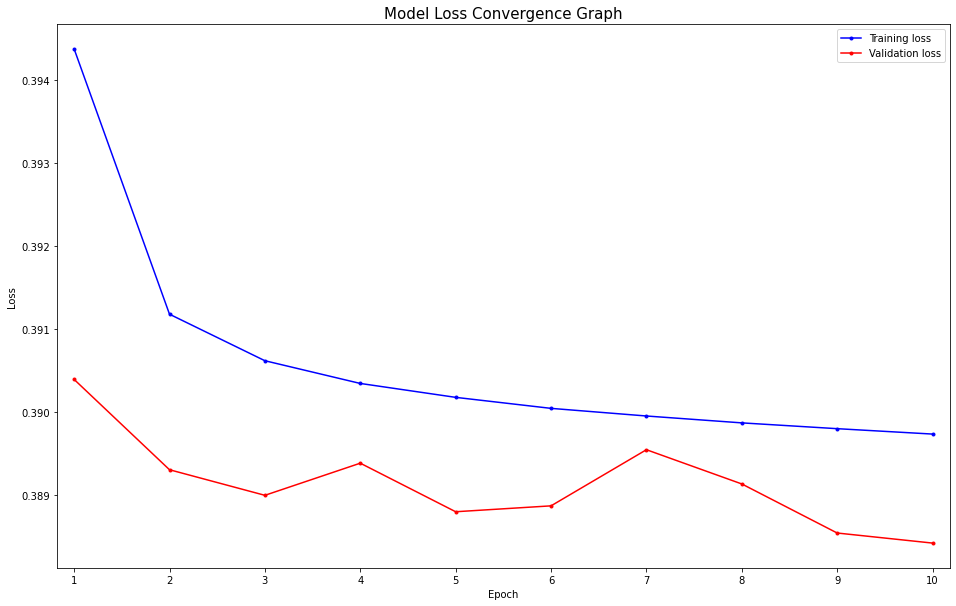

In [62]:
# 손실 그래프!

plt.figure(figsize=(16, 10))
plt.title('Model Loss Convergence Graph', size='15')
y_tloss = history.history['loss']
y_vloss = history.history['val_loss']
x_len = np.arange(len(y_tloss))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(0,50), labels=range(1,51))

plt.plot(x_len, y_tloss, "o-", c="blue", markersize=3)
plt.plot(x_len, y_vloss, "o-", c="red", markersize=3)
plt.margins(x=0.02)
plt.legend(['Training loss', 'Validation loss'])
plt.savefig('C:/Users/PC/표/수요예측/Model_Loss_Convergence_Graph.png')
plt.show

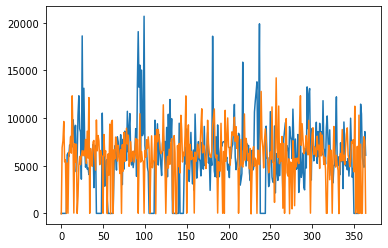

In [47]:
pred_365 = pred[0:365]
y_valid_365 = y_valid_check[0:365]

fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_valid_365, label='True')
ax.plot(pred_365, label='Prediction')

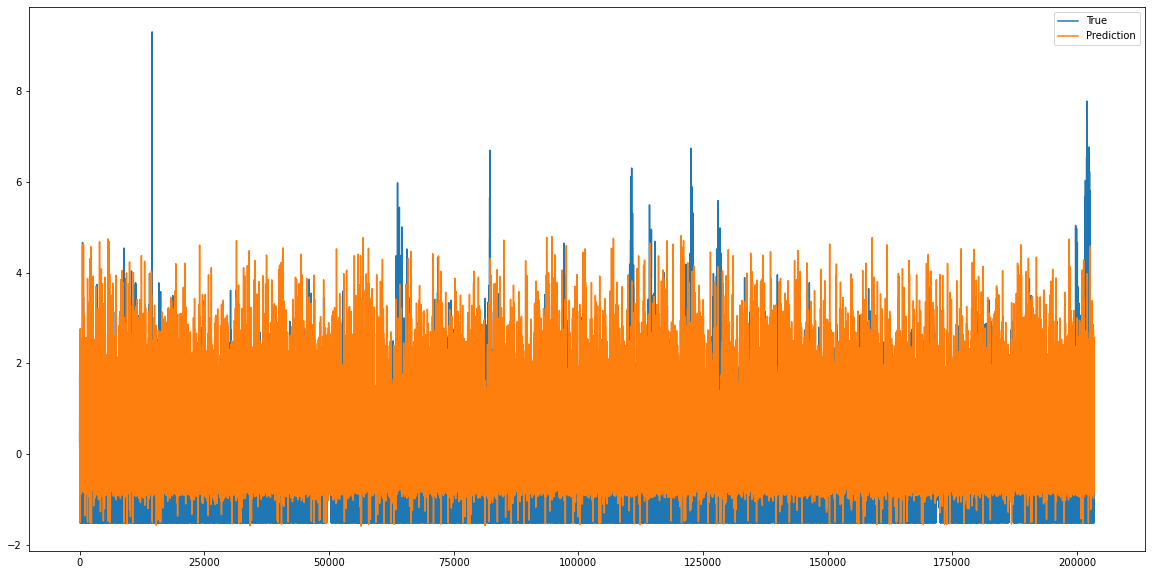

In [33]:
y_valid1 = y_valid1.values.tolist()
y_valid1 = np.array(y_valid1)
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_valid1, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()